### Packages

In [2]:

import importlib, import_ipynb
import data_clean_order_combined as data
#importlib.reload(data)

# Data processing
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras import preprocessing as kprocessing
from tensorflow.keras import models, layers, optimizers

import transformers

# Text processing
import re
import nltk
import gensim.downloader as api

# Various
from datetime import datetime

import matplotlib.pyplot as plt

%matplotlib inline

# matplotlib defaults
plt.style.use("ggplot")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

import warnings 
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

### Loading ordered data from data_clean_order_text.ipynb

In [3]:
%store -r rand_shuffled_text
%store -r ordered_super_alpha_text
%store -r ordered_class_alpha_text
%store -r ordered_sem_clusters_desc_text
%store -r ordered_sem_clusters_asc_text
%store -r ordered_sem_clusters_shuffled_per_superclass_text
%store -r test_df

In [4]:
ordered_sem_clusters_shuffled_per_superclass_text.head(5)

,headline,class,superclass,short_description,cleaned_headline,cleaned_short_description,combined
76371,"Prince Harry Helps Woman In Wheelchair Who Fell, Proves Again He's Pretty Darn Perfect",GOOD NEWS,POLITICS,So we're proposing that Prince Harry change his name to Prince Charming.,prince harry help woman wheelchair fell prove pretty darn perfect,propose prince harry change name prince charm,prince harry help woman wheelchair fell prove pretty darn perfect propose prince harry change name prince charm
57754,This Nonprofit's Shelter Pup Sleepovers Aim To Help Spur Adoption,GOOD NEWS,POLITICS,This is really upping the sleepover game.,nonprofits shelter pup sleepovers aim help spur adoption,really up sleepover game,nonprofits shelter pup sleepovers aim help spur adoption really up sleepover game
101093,"For Past 3 Years, Teen Has Carried Fellow Student Who Has Muscular Dystrophy To Class",GOOD NEWS,POLITICS,,past years teen carry fellow student muscular dystrophy class,,past years teen carry fellow student muscular dystrophy class
43345,Bridging The Divide At The Checkout Line,GOOD NEWS,POLITICS,I have a confession: I absolutely LOVE grocery shopping. I don’t know what it is about it – the predictability of the aisles,bridge divide checkout line,confession absolutely love grocery shop know predictability aisles,bridge divide checkout line confession absolutely love grocery shop know predictability aisles
67186,Dog Who Was Born In A Shelter Can't Stop Kissing His New Baby,GOOD NEWS,POLITICS,"When a family in Iowa welcomed a baby girl into their home recently, a dog named Blake was among the first to greet her.",dog bear shelter cannot stop kiss new baby,family iowa welcome baby girl home recently dog name blake among first greet,dog bear shelter cannot stop kiss new baby family iowa welcome baby girl home recently dog name blake among first greet


In [21]:
# TRAIN EXAMPLES
XB_train = rand_shuffled_text['combined'].to_frame()
X1_train = ordered_super_alpha_text['combined'].to_frame()
X2_train = ordered_class_alpha_text['combined'].to_frame()
X3_train = ordered_sem_clusters_desc_text['combined'].to_frame()
X4_train = ordered_sem_clusters_asc_text['combined'].to_frame()
X5_train = ordered_sem_clusters_shuffled_per_superclass_text['combined'].to_frame()

# TRAIN LABELS
YB_train = rand_shuffled_text['superclass']
Y1_train = ordered_super_alpha_text['superclass']
Y2_train = ordered_class_alpha_text['superclass']
Y3_train = ordered_sem_clusters_desc_text['superclass']
Y4_train = ordered_sem_clusters_asc_text['superclass']
Y5_train = ordered_sem_clusters_shuffled_per_superclass_text['superclass']

# TEST EXAMPLES
X_test = test_df['combined']
Y_test = test_df['superclass']

In [22]:
YB_train[:100]

8452        COMMUNITIES
42174          POLITICS
90062            HEALTH
119426           SOCIAL
127707     SCIENCE_TECH
              ...      
50933     ENTERTAINMENT
16344          POLITICS
188010           HEALTH
51872          POLITICS
164258           FAMILY
Name: superclass, Length: 100, dtype: object

In [23]:
Y1_train[:100]

0     COMMUNITIES
1     COMMUNITIES
2     COMMUNITIES
3     COMMUNITIES
4     COMMUNITIES
         ...     
95    COMMUNITIES
96    COMMUNITIES
97    COMMUNITIES
98    COMMUNITIES
99    COMMUNITIES
Name: superclass, Length: 100, dtype: object

In [24]:
Y2_train[:100]

0     CULTURE
1     CULTURE
2     CULTURE
3     CULTURE
4     CULTURE
       ...   
95    CULTURE
96    CULTURE
97    CULTURE
98    CULTURE
99    CULTURE
Name: superclass, Length: 100, dtype: object

In [25]:
Y3_train[:100]

124413    POLITICS
30957     POLITICS
24312     POLITICS
7288      POLITICS
27077     POLITICS
            ...   
19524     POLITICS
36084     POLITICS
122753    POLITICS
69285     POLITICS
25933     POLITICS
Name: superclass, Length: 100, dtype: object

In [26]:
Y4_train[:100]

172426    CULTURE
176361    CULTURE
151252    CULTURE
141925    CULTURE
198486    CULTURE
           ...   
143854    CULTURE
648       CULTURE
167684    CULTURE
169692    CULTURE
164990    CULTURE
Name: superclass, Length: 100, dtype: object

In [27]:
Y5_train[:100]

76371     POLITICS
57754     POLITICS
101093    POLITICS
43345     POLITICS
67186     POLITICS
            ...   
113389    POLITICS
68705     POLITICS
89854     POLITICS
129676    POLITICS
61466     POLITICS
Name: superclass, Length: 100, dtype: object

In [28]:
Y_test[:100]

54871        POLITICS
25625        POLITICS
48772     COMMUNITIES
114382      LIFESTYLE
75653        POLITICS
             ...     
6049         POLITICS
23369       LIFESTYLE
29132        POLITICS
137626         HEALTH
90732        POLITICS
Name: superclass, Length: 100, dtype: object

## Tokenization and Vectorization

### Cleaning X sets

In [29]:
# Reference: Text Classification with NLP: Tf-Idf vs Word2Vec vs BERT from Medium

# Use stopwords list from nltk
lst_stopwords = nltk.corpus.stopwords.words("english")

def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    # Clean (convert to lowercase and remove punctuations and characters and then strip)
    # The function is not optimized for speed but split into various steps for pedagogical purpose
    text = str(text).lower()
    text = text.strip()
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize (convert from string to list)
    lst_text = text.split()
    # remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]

    # Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]

    # Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]

    # back to string from list
    text = " ".join(lst_text)
    return text

In [33]:
def process_X(df):

    # Let's apply this function to the whole corpus
    df["text_clean"] = df["combined"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))

    # Let's look at the output
    #display(f.head())

    return df

In [34]:
XB_train = process_X(XB_train)
X1_train = process_X(X1_train)
X2_train = process_X(X2_train)
X3_train = process_X(X3_train)
X4_train = process_X(X4_train)
X5_train = process_X(X5_train)

In [35]:
print(YB_train.value_counts())
print(Y4_train.value_counts())

POLITICS         39472
ENTERTAINMENT    32464
HEALTH           22888
LIFESTYLE        19879
FAMILY           15822
COMMUNITIES      12466
SCIENCE_TECH      9741
SOCIAL            9398
CULTURE           5486
Name: superclass, dtype: int64
POLITICS         39472
ENTERTAINMENT    32464
HEALTH           22888
LIFESTYLE        19879
FAMILY           15822
COMMUNITIES      12466
SCIENCE_TECH      9741
SOCIAL            9398
CULTURE           5486
Name: superclass, dtype: int64


## Vectorizing

In [36]:
corpus = XB_train
# Initizalize the vectorizer with max nr words and ngrams (1: single words, 2: two words in a row)
vectorizer_tfidf = TfidfVectorizer(max_features=15000, ngram_range=(1,2))
# Fit the vectorizer to the training data
vectorizer_tfidf.fit(corpus)
TfidfVectorizer(max_features=15000, ngram_range=(1, 2))

TfidfVectorizer(max_features=15000, ngram_range=(1, 2))

# BASELINE ORDER - RAND SHUFFLED

In [40]:
X_train = XB_train['text_clean']
y_train = YB_train

classifier_tfidf = LogisticRegression()
model_tfidf = Pipeline([("vectorizer", vectorizer_tfidf), ("classifier", classifier_tfidf)])

start_time = datetime.now()
model_tfidf.fit(X_train, y_train)
end_time = datetime.now()

training_time_tfidf = (end_time - start_time).total_seconds()

Accuracy Training data: 75.0%
Accuracy Test data: 68.8%
Training time: 55.9s
               precision    recall  f1-score   support

  COMMUNITIES       0.64      0.47      0.54      3165
      CULTURE       0.60      0.33      0.43      1379
ENTERTAINMENT       0.64      0.77      0.70      8052
       FAMILY       0.75      0.70      0.72      4003
       HEALTH       0.66      0.75      0.70      5817
    LIFESTYLE       0.78      0.77      0.77      4945
     POLITICS       0.74      0.79      0.76      9846
 SCIENCE_TECH       0.59      0.49      0.54      2316
       SOCIAL       0.59      0.37      0.45      2382

     accuracy                           0.69     41905
    macro avg       0.66      0.60      0.62     41905
 weighted avg       0.68      0.69      0.68     41905



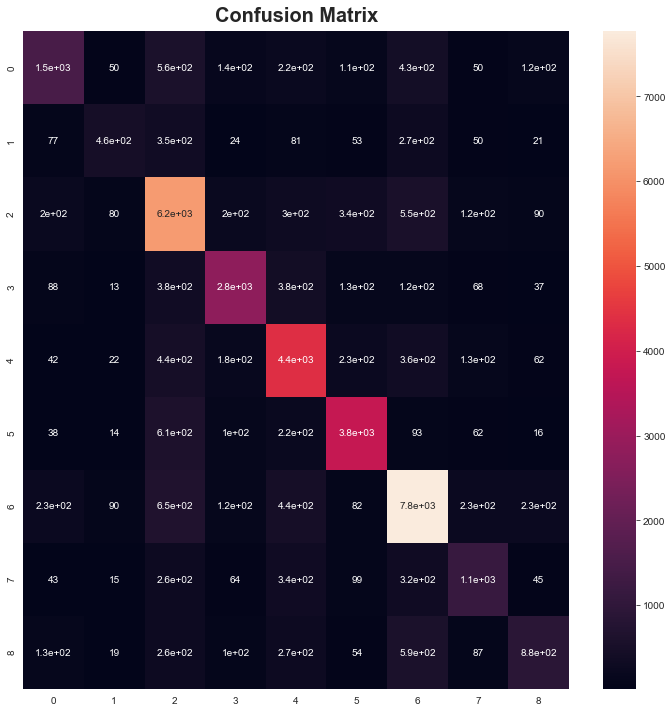

In [41]:
predicted_train_tfidf = model_tfidf.predict(X_train)
accuracy_train_tfidf = accuracy_score(y_train, predicted_train_tfidf)
print('Accuracy Training data: {:.1%}'.format(accuracy_train_tfidf))

predicted_test_tfidf = model_tfidf.predict(X_test)
accuracy_test_tfidf = accuracy_score(Y_test, predicted_test_tfidf)
accuracy_tfidf = accuracy_test_tfidf
print('Accuracy Test data: {:.1%}'.format(accuracy_test_tfidf))

print('Training time: {:.1f}s'.format(training_time_tfidf))

print(classification_report(Y_test, predicted_test_tfidf))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(Y_test, predicted_test_tfidf), annot=True);
plt.title('Confusion Matrix', fontsize=20);

# EXPERIMENT ORDER 1

In [43]:
X_train = X1_train['text_clean']
y_train = Y1_train

classifier_tfidf = LogisticRegression()
model_tfidf = Pipeline([("vectorizer", vectorizer_tfidf), ("classifier", classifier_tfidf)])

start_time = datetime.now()
model_tfidf.fit(X_train, y_train)
end_time = datetime.now()

training_time_tfidf = (end_time - start_time).total_seconds()

Accuracy Training data: 75.0%
Accuracy Test data: 68.6%
Training time: 55.5s
               precision    recall  f1-score   support

  COMMUNITIES       0.64      0.45      0.53      3165
      CULTURE       0.61      0.31      0.41      1379
ENTERTAINMENT       0.63      0.77      0.69      8052
       FAMILY       0.75      0.69      0.72      4003
       HEALTH       0.65      0.76      0.70      5817
    LIFESTYLE       0.78      0.75      0.77      4945
     POLITICS       0.74      0.79      0.77      9846
 SCIENCE_TECH       0.59      0.48      0.53      2316
       SOCIAL       0.59      0.36      0.44      2382

     accuracy                           0.69     41905
    macro avg       0.66      0.60      0.62     41905
 weighted avg       0.68      0.69      0.68     41905



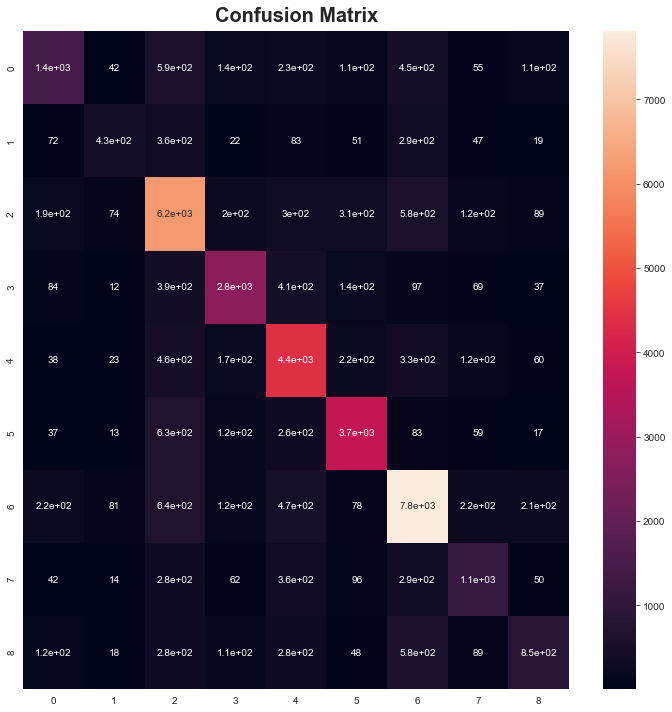

In [44]:
predicted_train_tfidf = model_tfidf.predict(X_train)
accuracy_train_tfidf = accuracy_score(y_train, predicted_train_tfidf)
print('Accuracy Training data: {:.1%}'.format(accuracy_train_tfidf))

predicted_test_tfidf = model_tfidf.predict(X_test)
accuracy_test_tfidf = accuracy_score(Y_test, predicted_test_tfidf)
accuracy_tfidf = accuracy_test_tfidf
print('Accuracy Test data: {:.1%}'.format(accuracy_test_tfidf))

print('Training time: {:.1f}s'.format(training_time_tfidf))

print(classification_report(Y_test, predicted_test_tfidf))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(Y_test, predicted_test_tfidf), annot=True);
plt.title('Confusion Matrix', fontsize=20);

# EXPERIMENT ORDER 2

In [45]:
X_train = X2_train['text_clean']
y_train = Y2_train

classifier_tfidf = LogisticRegression()
model_tfidf = Pipeline([("vectorizer", vectorizer_tfidf), ("classifier", classifier_tfidf)])

start_time = datetime.now()
model_tfidf.fit(X_train, y_train)
end_time = datetime.now()

training_time_tfidf = (end_time - start_time).total_seconds()

Accuracy Training data: 75.0%
Accuracy Test data: 68.6%
Training time: 59.3s
               precision    recall  f1-score   support

  COMMUNITIES       0.65      0.44      0.53      3165
      CULTURE       0.62      0.30      0.41      1379
ENTERTAINMENT       0.63      0.78      0.69      8052
       FAMILY       0.74      0.70      0.72      4003
       HEALTH       0.65      0.75      0.70      5817
    LIFESTYLE       0.78      0.76      0.77      4945
     POLITICS       0.74      0.79      0.77      9846
 SCIENCE_TECH       0.60      0.48      0.53      2316
       SOCIAL       0.58      0.37      0.45      2382

     accuracy                           0.69     41905
    macro avg       0.67      0.60      0.62     41905
 weighted avg       0.68      0.69      0.68     41905



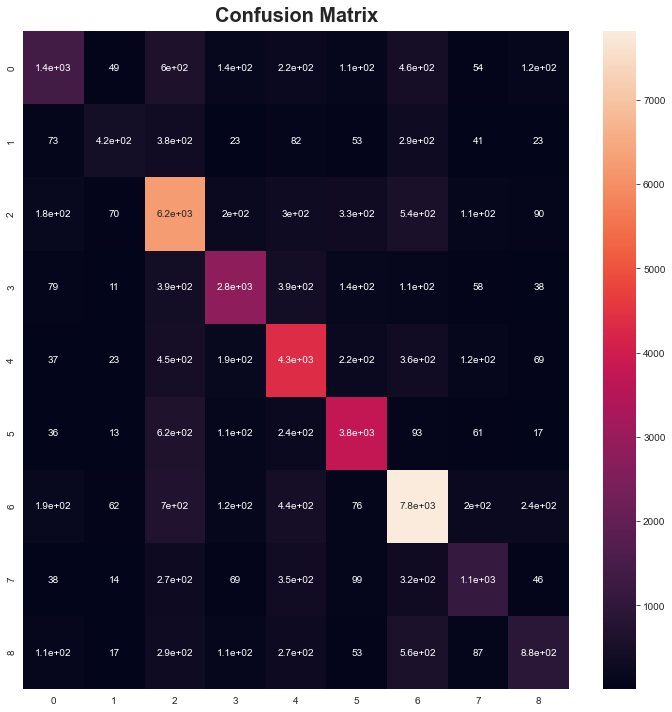

In [46]:
predicted_train_tfidf = model_tfidf.predict(X_train)
accuracy_train_tfidf = accuracy_score(y_train, predicted_train_tfidf)
print('Accuracy Training data: {:.1%}'.format(accuracy_train_tfidf))

predicted_test_tfidf = model_tfidf.predict(X_test)
accuracy_test_tfidf = accuracy_score(Y_test, predicted_test_tfidf)
accuracy_tfidf = accuracy_test_tfidf
print('Accuracy Test data: {:.1%}'.format(accuracy_test_tfidf))

print('Training time: {:.1f}s'.format(training_time_tfidf))

print(classification_report(Y_test, predicted_test_tfidf))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(Y_test, predicted_test_tfidf), annot=True);
plt.title('Confusion Matrix', fontsize=20);

# EXPERIMENT ORDER 3

In [47]:
X_train = X3_train['text_clean']
y_train = Y3_train

classifier_tfidf = LogisticRegression()
model_tfidf = Pipeline([("vectorizer", vectorizer_tfidf), ("classifier", classifier_tfidf)])

start_time = datetime.now()
model_tfidf.fit(X_train, y_train)
end_time = datetime.now()

training_time_tfidf = (end_time - start_time).total_seconds()

Accuracy Training data: 75.1%
Accuracy Test data: 68.8%
Training time: 55.7s
               precision    recall  f1-score   support

  COMMUNITIES       0.64      0.46      0.54      3165
      CULTURE       0.60      0.33      0.43      1379
ENTERTAINMENT       0.65      0.76      0.70      8052
       FAMILY       0.74      0.70      0.72      4003
       HEALTH       0.66      0.75      0.70      5817
    LIFESTYLE       0.77      0.77      0.77      4945
     POLITICS       0.73      0.80      0.76      9846
 SCIENCE_TECH       0.60      0.48      0.53      2316
       SOCIAL       0.59      0.36      0.45      2382

     accuracy                           0.69     41905
    macro avg       0.66      0.60      0.62     41905
 weighted avg       0.68      0.69      0.68     41905



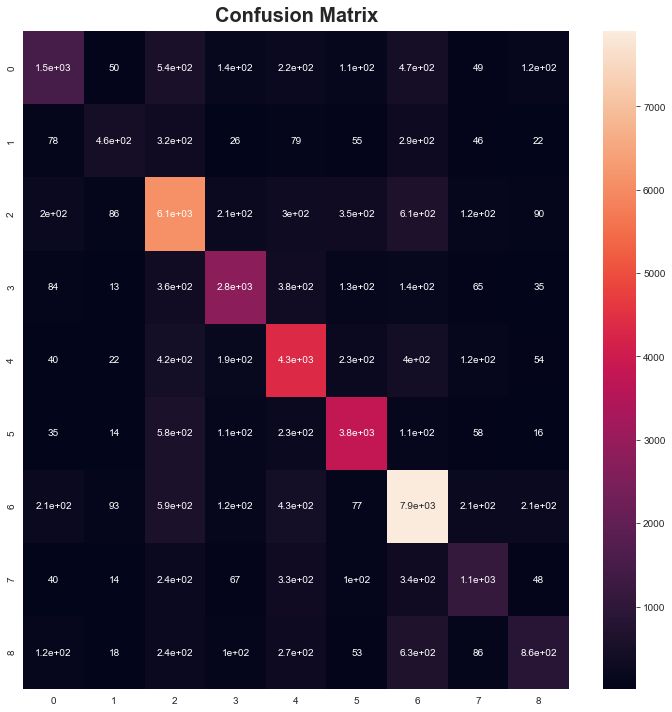

In [48]:
predicted_train_tfidf = model_tfidf.predict(X_train)
accuracy_train_tfidf = accuracy_score(y_train, predicted_train_tfidf)
print('Accuracy Training data: {:.1%}'.format(accuracy_train_tfidf))

predicted_test_tfidf = model_tfidf.predict(X_test)
accuracy_test_tfidf = accuracy_score(Y_test, predicted_test_tfidf)
accuracy_tfidf = accuracy_test_tfidf
print('Accuracy Test data: {:.1%}'.format(accuracy_test_tfidf))

print('Training time: {:.1f}s'.format(training_time_tfidf))

print(classification_report(Y_test, predicted_test_tfidf))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(Y_test, predicted_test_tfidf), annot=True);
plt.title('Confusion Matrix', fontsize=20);

# EXPERIMENT ORDER 4

In [49]:
X_train = X4_train['text_clean']
y_train = Y4_train

classifier_tfidf = LogisticRegression()
model_tfidf = Pipeline([("vectorizer", vectorizer_tfidf), ("classifier", classifier_tfidf)])

start_time = datetime.now()
model_tfidf.fit(X_train, y_train)
end_time = datetime.now()

training_time_tfidf = (end_time - start_time).total_seconds()

Accuracy Training data: 75.2%
Accuracy Test data: 68.7%
Training time: 55.5s
               precision    recall  f1-score   support

  COMMUNITIES       0.65      0.45      0.53      3165
      CULTURE       0.60      0.32      0.42      1379
ENTERTAINMENT       0.64      0.77      0.70      8052
       FAMILY       0.75      0.69      0.72      4003
       HEALTH       0.66      0.75      0.70      5817
    LIFESTYLE       0.78      0.76      0.77      4945
     POLITICS       0.74      0.80      0.76      9846
 SCIENCE_TECH       0.59      0.49      0.54      2316
       SOCIAL       0.58      0.37      0.45      2382

     accuracy                           0.69     41905
    macro avg       0.66      0.60      0.62     41905
 weighted avg       0.68      0.69      0.68     41905



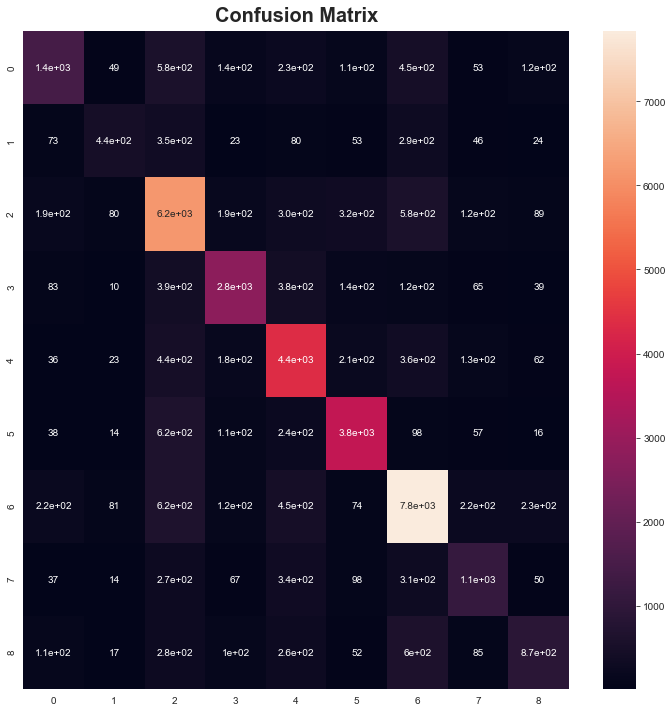

In [50]:
predicted_train_tfidf = model_tfidf.predict(X_train)
accuracy_train_tfidf = accuracy_score(y_train, predicted_train_tfidf)
print('Accuracy Training data: {:.1%}'.format(accuracy_train_tfidf))

predicted_test_tfidf = model_tfidf.predict(X_test)
accuracy_test_tfidf = accuracy_score(Y_test, predicted_test_tfidf)
accuracy_tfidf = accuracy_test_tfidf
print('Accuracy Test data: {:.1%}'.format(accuracy_test_tfidf))

print('Training time: {:.1f}s'.format(training_time_tfidf))

print(classification_report(Y_test, predicted_test_tfidf))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(Y_test, predicted_test_tfidf), annot=True);
plt.title('Confusion Matrix', fontsize=20);

# EXPERIMENT ORDER 5

In [51]:
X_train = X5_train['text_clean']
y_train = Y5_train

classifier_tfidf = LogisticRegression()
model_tfidf = Pipeline([("vectorizer", vectorizer_tfidf), ("classifier", classifier_tfidf)])

start_time = datetime.now()
model_tfidf.fit(X_train, y_train)
end_time = datetime.now()

training_time_tfidf = (end_time - start_time).total_seconds()

Accuracy Training data: 75.1%
Accuracy Test data: 68.8%
Training time: 56.0s
               precision    recall  f1-score   support

  COMMUNITIES       0.64      0.46      0.54      3165
      CULTURE       0.60      0.33      0.43      1379
ENTERTAINMENT       0.65      0.76      0.70      8052
       FAMILY       0.74      0.70      0.72      4003
       HEALTH       0.66      0.75      0.70      5817
    LIFESTYLE       0.77      0.77      0.77      4945
     POLITICS       0.73      0.80      0.76      9846
 SCIENCE_TECH       0.60      0.48      0.53      2316
       SOCIAL       0.59      0.36      0.45      2382

     accuracy                           0.69     41905
    macro avg       0.66      0.60      0.62     41905
 weighted avg       0.68      0.69      0.68     41905



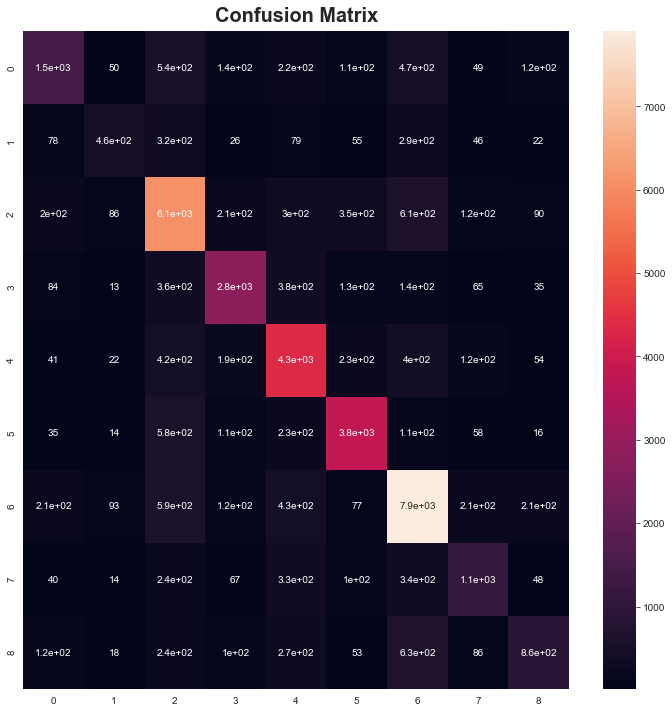

In [52]:
predicted_train_tfidf = model_tfidf.predict(X_train)
accuracy_train_tfidf = accuracy_score(y_train, predicted_train_tfidf)
print('Accuracy Training data: {:.1%}'.format(accuracy_train_tfidf))

predicted_test_tfidf = model_tfidf.predict(X_test)
accuracy_test_tfidf = accuracy_score(Y_test, predicted_test_tfidf)
accuracy_tfidf = accuracy_test_tfidf
print('Accuracy Test data: {:.1%}'.format(accuracy_test_tfidf))

print('Training time: {:.1f}s'.format(training_time_tfidf))

print(classification_report(Y_test, predicted_test_tfidf))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(Y_test, predicted_test_tfidf), annot=True);
plt.title('Confusion Matrix', fontsize=20);